# Dogs vs Cats with Standard Learning

In this Notebook we're going to use transfer learning to attempt to crack the [Dogs vs Cats Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats). This time, we will omit the use of the VGG-16 pretrained network.

We are going to downsample the images to 64x64; that's pretty small, but should be enough (I hope). Furthermore, large images means longer training time and I'm too impatient for that. ;)

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `os`, `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. We also want to import some layer classes and utilities from Lasagne for convenience.

In [2]:
import os, glob, time, tqdm
import numpy as np
from matplotlib import pyplot as plt
import skimage, skimage.util, skimage.io, skimage.transform
import theano
import lasagne

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 25.0% of memory, cuDNN 5105)


Define functions for shuffling the dimensions between image order `(height, width, channel)` and network order `(sample, channel, height, width)`:

In [3]:
def img_to_net(img):
    # (H, W, C) -> (B, C, H, W)
    img = img[None, :, :, :].transpose(0, 3, 1, 2)
    return img.astype(np.float32)

def net_to_img(img):
    # (B, C, H, W) -> (H, W, C)
    img = img[0, :, :, :].transpose(1, 2, 0)
    return img.astype(np.float32)

## Load our dataset

Join the Kaggle competition linked above and download the training and test data sets. Unzip them into a directory of your chooseing, and modify the path definitions below to point to the appropriate location:

In [4]:
TRAIN_PATH = r'E:\datasets\dogsvscats\train'
TEST_PATH = r'E:\datasets\dogsvscats\test1'

train_image_paths = glob.glob(os.path.join(TRAIN_PATH, '*.jpg'))
tests_image_paths = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

Now we will define a function that will load an image from the given path, scale it to 64x64 while preserving aspect ratio, and convert it's colour space:

In [5]:
def load_image(path):
    # Read
    img = skimage.io.imread(path)
    # Convert to float
    img = skimage.util.img_as_float(img)
    # Compute scaled dimensions, while preserving aspect ratio
    # py0, py1, px0, px1 are the padding required to get the image to 64x64
    if img.shape[0] >= img.shape[1]:
        height = 64
        width = int(img.shape[1] * 64.0 / float(img.shape[0]) + 0.5)
        py0 = py1 = 0
        px0 = (64 - width) // 2
        px1 = (64 - width) - px0
    else:
        width = 64
        height = int(img.shape[0] * 64.0 / float(img.shape[1]) + 0.5)
        px0 = px1 = 0
        py0 = (64 - height) // 2
        py1 = (64 - height) - py0
    img = skimage.transform.resize(img, (height, width))
    
    # Convert for use with net
    img = img_to_net(img)
    
    # Apply padding, with constant value of -1 so that we can identify padded pixels later on:
    img = np.pad(img, [(0, 0), (0, 0), (py0, py1), (px0, px1)], mode='constant', constant_values=-1.0)
    
    return img

Show an image to check our code so far:

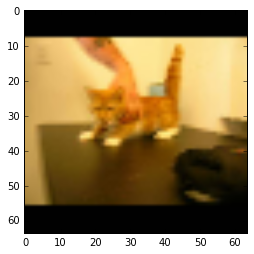

In [6]:
plt.imshow(net_to_img(load_image(train_image_paths[0])))
plt.show()

Looks okay.

#### Build the data set:

In [7]:
t1 = time.time()
# Load all image samples
data_X = []
for p in tqdm.tqdm_notebook(train_image_paths):
    data_X.append(load_image(p))

# Concatenate along axis 0 (sample axis)
data_X = np.concatenate(data_X, axis=0).astype(np.float32)
t2 = time.time()

print('Loaded {} images in {:.2f}s'.format(len(train_image_paths), t2 - t1))


Loaded 25000 images in 254.18s


In [8]:
# The ground truth classifications are given by the filename having either a 'dog.' or 'cat.' prefix
# Use:
# 0: cat
# 1: dog
data_y = [(1 if os.path.basename(p).lower().startswith('dog.') else 0) for p in train_image_paths]
data_y = np.array(data_y).astype(np.int32)

print('{} cats, {} dogs'.format((data_y == 0).sum(), (data_y == 1).sum()))

12500 cats, 12500 dogs


#### Split the dataset into train and validation

Note that we implement the split manually here. We could easily use [sklearn.model_selection.StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit). I am refraining for now due to the API changes.

In [9]:
# Create a RNG that we will use throughout the notebook:
rng = np.random.RandomState(12345)

# Get the indices of samples that are dogs and cats
dog_ndx = np.where(data_y == 1)[0]
cat_ndx = np.where(data_y == 0)[0]

# Shuffle them, so that we make a random split
rng.shuffle(dog_ndx)
rng.shuffle(cat_ndx)

# There are 12,500 of each in the data set.
# Build a mask that indicates the samples that are in the validation set
val_mask = np.zeros(data_y.shape, dtype=bool)
# Choose 1250 as validation from each class
val_mask[dog_ndx[:1250]] = True
val_mask[cat_ndx[:1250]] = True

# Now split the data:
val_X = data_X[val_mask]
val_y = data_y[val_mask]

train_X = data_X[~val_mask]
train_y = data_y[~val_mask]

print('Train: X.shape={}, y.shape={}; val: X.shape={}, y.shape={}'.format(train_X.shape, train_y.shape, val_X.shape, val_y.shape))

Train: X.shape=(22500L, 3L, 64L, 64L), y.shape=(22500L,); val: X.shape=(2500L, 3L, 64L, 64L), y.shape=(2500L,)


Delete the original arrays to free up some RAM:

In [10]:
del data_X, data_y

## Perform data standardisation

In [11]:
# Flatten training set to get all RGB samples
train_rgb = train_X.transpose(0, 2, 3, 1).reshape((-1, 3))
# Select the samples that are not -1 and therefore not padded pixels
not_pad = train_rgb[:, 0] != -1
train_rgb = train_rgb[not_pad, :]

# Compute the mean and std-dev
mean_rgb = train_rgb.mean(axis=0)
std_rgb = train_rgb.std(axis=0)

# Don't need; save memory
del train_rgb

# Mask pixels that are padding:
train_mask = train_X == -1.0
val_mask = val_X == -1.0

# Apply standardisation:
train_X = (train_X - mean_rgb[None, :, None, None]) / std_rgb[None, :, None, None]
val_X = (val_X - mean_rgb[None, :, None, None]) / std_rgb[None, :, None, None]

# Set padding pixels to 0:
train_X[train_mask] = 0.0
val_X[val_mask] = 0.0

## Build the network

Now we will use the Lasagne API to build the pet classifier network.

Use the same architecture as with transfer learning:

In [12]:
def build_pet_classifier_network():
    net = {}
    # Input layer: shape is of the form (sample, channel, height, width).
    # We are using 3 channel images of size 64 x 64.
    # We leave the sample dimension with no size (`None`) so that the
    # minibatch size is whatever we need it to be when we use it
    net['input'] = InputLayer((None, 3, 64, 64))
    
    # First two convolutional layers: 48 filters, 3x3 convolution, 1 pixel padding
    net['conv1_1'] = Conv2DLayer(net['input'], 48, 3, pad=1, W=lasagne.init.HeUniform())
    net['conv1_2'] = Conv2DLayer(net['conv1_1'], 48, 3, pad=1, W=lasagne.init.HeUniform())
    net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
    
    # Two convolutional layers, 96 filters
    net['conv2_1'] = Conv2DLayer(net['pool1'], 96, 3, pad=1, W=lasagne.init.HeUniform())
    net['conv2_2'] = Conv2DLayer(net['conv2_1'], 96, 3, pad=1, W=lasagne.init.HeUniform())
    net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
    
    # Two convolutional layers, 192 filters
    net['conv3_1'] = Conv2DLayer(net['pool2'], 192, 3, pad=1, W=lasagne.init.HeUniform())
    net['conv3_2'] = Conv2DLayer(net['conv3_1'], 192, 3, pad=1, W=lasagne.init.HeUniform())
    net['pool3'] = Pool2DLayer(net['conv3_2'], 2)
    
    # Two convolutional layers, 384 filters
    net['conv4_1'] = Conv2DLayer(net['pool3'], 384, 3, pad=1, W=lasagne.init.HeUniform())
    net['conv4_2'] = Conv2DLayer(net['conv4_1'], 384, 3, pad=1, W=lasagne.init.HeUniform())
    net['pool4'] = Pool2DLayer(net['conv4_2'], 2)
    
    # Two convolutional layers, 384 filters
    net['conv5_1'] = Conv2DLayer(net['pool4'], 384, 3, pad=1, W=lasagne.init.HeUniform())
    net['conv5_2'] = Conv2DLayer(net['conv5_1'], 384, 3, pad=1, W=lasagne.init.HeUniform())
    net['pool5'] = Pool2DLayer(net['conv5_2'], 2)
    
    #
    # ALL LAYERS ABOVE ARE PRE-TRAINED
    #
    # ALL LAYERS BELOW ARE NEW
    #
    
    # Dense layer, 256 units
    net['fc6'] = DenseLayer(net['pool5'], num_units=256, W=lasagne.init.HeUniform())
    # 50% dropout (only applied during training, turned off during prediction)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    
    # Final dense layer, 2 units: 1 for each class
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2, nonlinearity=None, W=lasagne.init.HeUniform())
    # Softmax non-linearity that will generate probabilities
    net['prob'] = NonlinearityLayer(net['fc7'], softmax)

    return net

In [13]:
# Build it
pet_net = build_pet_classifier_network()

## Set up Theano variables, expressions and functions for training the classifier

Create variables for our a batch of input images `x` and a batch of targets `y`:

In [14]:
x_var = theano.tensor.tensor4('x')
y_var = theano.tensor.ivector('y')

Generate expressions for the network output, in both training mode (dropout on) and evaluation mode (dropout off, hence `deterministic=True`):

In [15]:
train_pred_prob = lasagne.layers.get_output(pet_net['prob'], x_var)
eval_pred_prob = lasagne.layers.get_output(pet_net['prob'], x_var, deterministic=True)

Expression for the predicted label in evaluation mode:

In [16]:
eval_pred_y = eval_pred_prob.argmax(axis=1)

Expressions for loss in training and evaluation mode and errors in evaluation mode:

In [17]:
train_losses = lasagne.objectives.categorical_crossentropy(train_pred_prob, y_var)
eval_losses = lasagne.objectives.categorical_crossentropy(eval_pred_prob, y_var)
eval_errs = theano.tensor.neq(eval_pred_y, y_var).astype(theano.config.floatX)

Get the pre-trained and new parameters and compute separate update dictionaries for them, using the ADAM rule:

In [18]:
params = lasagne.layers.get_all_params(pet_net['prob'], trainable=True)

train_loss = train_losses.mean()
train_updates = lasagne.updates.adam(train_loss, params, learning_rate=3e-4)

Compile Theano functions for training, evaluation and prediction:

In [19]:
print('Compiling train function...')
f_train = theano.function([x_var, y_var], train_losses.sum(), updates=train_updates)

Compiling train function...


In [20]:
print('Compiling evaluation function...')
f_eval = theano.function([x_var, y_var], [eval_losses.sum(), eval_errs.sum()])

Compiling evaluation function...


In [21]:
print('Compiling prediction function...')
f_pred = theano.function([x_var], eval_pred_prob)

Compiling prediction function...


## Train the network

Define functions for extracting mini-batches of data from the training and validation sets:

In [22]:
def train_batch_iter(batch_size):
    # Extract batches from the training set with samples in shuffled order
    # Number of samples
    n = train_y.shape[0]
    
    # Sample indices in shuffled order
    ndx = rng.permutation(n)
    
    n_batches = n // batch_size
    if (n % batch_size) > 0:
        n_batches += 1
    
    # Extract batches
    for i in range(0, n, batch_size):
        batch_ndx = ndx[i:i + batch_size]
        batch_X = train_X[batch_ndx]
        batch_y = train_y[batch_ndx]        
        yield batch_X, batch_y
        
        
def val_batch_iter(batch_size):
    # Extract batches from the validation set with samples in order
    # Number of samples
    n = val_y.shape[0]
    
    n_batches = n // batch_size
    if (n % batch_size) > 0:
        n_batches += 1
    
    # Extract batches
    for i in range(0, n, batch_size):
        batch_X = val_X[i:i + batch_size]
        batch_y = val_y[i:i + batch_size]        
        yield batch_X, batch_y

Define settings for training:

In [23]:
NUM_EPOCHS = 50

The training loop:

In [24]:
print('Training...')

for epoch_i in range(NUM_EPOCHS):
    t1 = time.time()
    
    # TRAIN
    train_loss = 0.0
    # For each batch:
    for batch_X, batch_y in train_batch_iter(128):
        # Accumulate training loss
        train_loss += f_train(batch_X, batch_y)
    # Divide by number of samples to get mean loss
    train_loss /= float(train_y.shape[0])
    
    # VALIDATE
    val_loss = val_err = 0.0
    # For each batch:
    for batch_X, batch_y in val_batch_iter(128):
        # Accumulate loss and error
        l, e = f_eval(batch_X, batch_y)
        val_loss += l
        val_err += e
    # Divide by number of samples to get mean loss and error
    val_loss /= float(val_y.shape[0])
    val_err /= float(val_y.shape[0])
    
    t2 = time.time()
    
    # REPORT
    print('Epoch {} took {:.2f}s: train loss={:.6f}; val loss={:.6f} err={:.2%}'.format(
            epoch_i, t2 - t1, train_loss, val_loss, val_err))

Training...
Epoch 0 took 31.47s: train loss=0.668873; val loss=0.682701 err=39.28%
Epoch 1 took 31.65s: train loss=0.585444; val loss=0.531969 err=25.20%
Epoch 2 took 31.95s: train loss=0.454245; val loss=0.423836 err=18.44%
Epoch 3 took 32.20s: train loss=0.351765; val loss=0.332053 err=14.80%
Epoch 4 took 32.32s: train loss=0.284822; val loss=0.315908 err=14.32%
Epoch 5 took 32.53s: train loss=0.215822; val loss=0.305609 err=13.88%
Epoch 6 took 32.55s: train loss=0.164023; val loss=0.300702 err=13.32%
Epoch 7 took 32.88s: train loss=0.122728; val loss=0.339982 err=12.84%
Epoch 8 took 32.90s: train loss=0.096470; val loss=0.354636 err=12.88%
Epoch 9 took 32.90s: train loss=0.067475; val loss=0.377165 err=12.72%
Epoch 10 took 32.87s: train loss=0.059533; val loss=0.375793 err=12.24%
Epoch 11 took 32.86s: train loss=0.040579; val loss=0.440871 err=12.68%
Epoch 12 took 32.80s: train loss=0.032790; val loss=0.478959 err=12.44%
Epoch 13 took 32.98s: train loss=0.029902; val loss=0.532791 e

### Apply to some example images from the test set

In [ ]:
# Number of samples to try
N_TEST = 15

# Shuffle test sample indcies
test_ndx = rng.permutation(len(tests_image_paths))

# Select first `N_TEST` samples
test_ndx = test_ndx[:N_TEST]

for test_i in test_ndx:
    # Load the image
    X = load_image(tests_image_paths[test_i])
    
    # Predict class probabilities
    pred_prob = f_pred((X - mean_rgb[None, :, None, None]) / std_rgb[None, :, None, None])
    # Get predicated class
    pred_y = np.argmax(pred_prob, axis=1)
    
    # Get class name
    pred_cls = 'dog' if pred_y[0] == 1 else 'cat'
    
    # Report
    print('Sample {}: predicted as {}, confidence {:.2%}'.format(test_i, pred_cls, pred_prob[0,pred_y[0]]))
    # Show the image
    plt.figure()
    plt.imshow(net_to_img(X))
    plt.show()